In [1]:
import numpy as np
import rcca
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import normalize

import torch
import umap

# from mcfa import mcfa_model
# from mcfa import gsea
from scipy import stats
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from statsmodels.stats import multitest

In [2]:
ephys = pd.read_pickle("D:/Data For Publication/CCA/ephys_with_labels.p")
ephys = ephys.drop_duplicates('exp_name')
bio = pd.read_pickle("D:/Data For Publication/CCA/biophys_with_labels.pkl")
bio = bio.drop_duplicates('exp_name')
sta = pd.read_pickle("D:/Data For Publication/CCA/sta_with_labels.pkl")
sta = sta.drop_duplicates('exp_name')
# sta_fleur = pd.read_pickle('D:/CurrentClamp/all_stas_fleur.pkl')
# sta_fleur = sta_fleur.drop_duplicates('exp_name')
# sta_fleur = sta_fleur[sta_fleur.exp_name.isin(sta.exp_name)]

In [3]:
df_ephys = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_spikes_calculated_5ms.pkl")
df_bio = pd.read_pickle("D:/Biophysical_cluster/rect_bio_all_feats.pkl")
df_sta = pd.read_pickle('D:/CurrentClamp/all_stas_hidden_spikes_computed.pkl')


In [4]:
ephys_exc  = ephys[~ephys.labels_wave.isin([0,4,5])] 
ephys_inh  = ephys[ephys.labels_wave.isin([0,4,5])] 


bio_exc =  bio[bio.labels_wave==1]
bio_inh =  bio[bio.labels_wave==0]

bio_exc = bio_exc[bio_exc.r_squared_V>0.7]
bio_inh = bio_inh[bio_inh.r_squared_V>0.7]

sta_exc = sta[sta.labels_wave==1]
sta_inh = sta[sta.labels_wave==0]

sta_exc = sta[sta.labels_wave==1]
sta_inh = sta[sta.labels_wave==0]



exc_exps = list(set(sta_exc.exp_name) & set(bio_exc.exp_name) & set(ephys_exc.exp_name))
inh_exps = list(set(sta_inh.exp_name) & set(bio_inh.exp_name) & set(ephys_inh.exp_name))


ephys_exc = ephys_exc[ephys_exc.exp_name.isin(exc_exps)]
ephys_inh = ephys_inh[ephys_inh.exp_name.isin(inh_exps)]


ephys_exc_all = df_ephys[df_ephys.exp_name.isin(exc_exps)]
ephys_inh_all = df_ephys[df_ephys.exp_name.isin(inh_exps)]



bio_exc = bio_exc[bio_exc.exp_name.isin(exc_exps)]
bio_inh = bio_inh[bio_inh.exp_name.isin(inh_exps)]

bio_exc_all = df_bio[df_bio.exp_name.isin(exc_exps)]
bio_inh_all = df_bio[df_bio.exp_name.isin(inh_exps)]

sta_exc = sta_exc[sta_exc.exp_name.isin(exc_exps)]
sta_inh = sta_inh[sta_inh.exp_name.isin(inh_exps)]

sta_exc_all = df_sta[df_sta.exp_name.isin(exc_exps)]
sta_inh_all = df_sta[df_sta.exp_name.isin(inh_exps)]

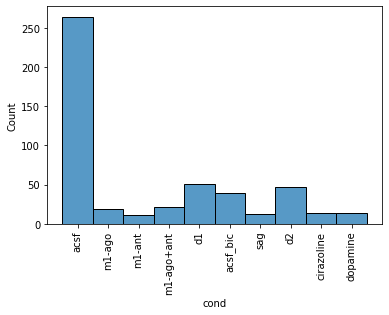

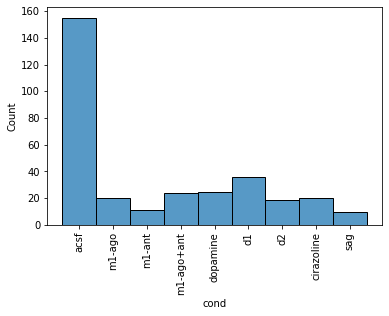

In [5]:
sns.histplot(df_ephys[df_ephys.exp_name.isin(exc_exps)].cond)
plt.xticks(rotation=90)
plt.show()

sns.histplot(df_ephys[df_ephys.exp_name.isin(inh_exps)].cond)
plt.xticks(rotation=90)
plt.show()

In [6]:
cols_ephys = ['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',]
cols_bio = ['tau_m (ms)', 'C (nF)', 'gl (nS)', 'El (mV)', 'Vr (mV)', 'Vt* (mV)', 'DV (mV)',]

## control

In [7]:
df_sta_exc = pd.DataFrame(columns=np.arange(np.vstack(sta_exc['sta'].to_numpy()).shape[1]))
df_sta_exc[df_sta_exc.columns] = normalize(np.vstack(sta_exc['sta'].to_numpy()))
bio_exc[cols_bio] = bio_exc[cols_bio].to_numpy(dtype=np.float32)

df_eta_exc = pd.DataFrame(columns=np.arange(10759))

df_eta_exc[df_eta_exc.columns]  = normalize(np.float32(np.vstack(bio_exc['eta'].to_numpy())))

ephys_exc[cols_ephys] = ephys_exc[cols_ephys].to_numpy(dtype=np.float32)

In [8]:
df_sta_inh = pd.DataFrame(columns=np.arange(np.vstack(sta_exc['sta'].to_numpy()).shape[1]))
df_sta_inh[df_sta_inh.columns] =normalize(np.vstack(sta_inh['sta'].to_numpy()))
bio_inh[cols_bio] = bio_inh[cols_bio].to_numpy(dtype=np.float32)

df_eta_inh = pd.DataFrame(columns=np.arange(10759))
df_eta_inh[df_eta_inh.columns]  =  normalize(np.float32(np.vstack(bio_inh['eta'].to_numpy())))
ephys_inh[cols_ephys] = ephys_inh[cols_ephys].to_numpy(dtype=np.float32)

## neuromod

In [9]:
def return_neuromod_df(df:pd.DataFrame,cond:list,df_type:str,cols=None):

    if df_type=='sta':
        df_sta = pd.DataFrame(columns=np.arange(np.vstack(df['sta'].to_numpy()).shape[1]))
        df_sta[df_sta.columns] = normalize(np.vstack(df[df.cond.isin(cond)]['sta'].to_numpy()))
        return df_sta
    
    elif df_type=='bio':
        df_bio = pd.DataFrame(columns=cols)
        df_bio[cols] = df[df.cond.isin(cond)][cols].to_numpy(dtype=np.float32)
        return df_bio
    
    elif df_type=='eta':    
        df_eta_exc_all = pd.DataFrame(columns=np.arange(10759))
        df_eta_exc_all[df_eta_exc_all.columns]  = normalize(np.float32(np.vstack(df[df.cond.isin(cond)]['eta'].to_numpy())))
        return df_eta_exc_all
             
    elif df_type=='ephys':    
        df_ephys = pd.DataFrame(columns=cols)
        df_ephys[cols] = df[df.cond.isin(cond)][cols].to_numpy(dtype=np.float32)

        return df_ephys

# control

In [10]:
from multicor_fa import mcfa_model

Y_inh = {
    "ephys": ephys_inh[cols_ephys].reset_index(drop='index'), 
    "bio": bio_inh[cols_bio].reset_index(drop='index'), 
    "sta": df_sta_inh,
    'eta':df_eta_inh
    }

Y_exc = {
    "ephys": ephys_exc[cols_ephys].reset_index(drop='index'), 
    "bio": bio_exc[cols_bio].reset_index(drop='index'), 
    "sta": df_sta_exc,
    'eta':df_eta_exc
    }



mcfa_res_inh = mcfa_model.fit(Y_inh,k=[2,1,2,2]) 
mcfa_res_exc = mcfa_model.fit(Y_exc,k=[2,1,2,2])    

Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 3 components above rho inclusion threshold 1.5865678787231445.
Fitting the model.
iter: 0 Likelihood: 7239.1962890625
Iter: 1 Likelihood: 7134.63720703125 Percent change: 0.014655136483773284 Time (s): 0.00500941276550293
Iter: 2 Likelihood: 7126.912109375 Percent change: 0.0010839333413538417 Time (s): 0.008503198623657227
Iter: 3 Likelihood: 7123.38232421875 Percent change: 0.0004955209471558339 Time (s): 0.011544942855834961
Iter: 4 Likelihood: 7121.46142578125 Percent change: 0.00026973374180556915 Time (s): 0.014021873474121094
Iter: 5 Likelihood: 7120.2138671875 Percent change: 0.0001752136406322284 Time (s): 0.016032695770263672
Iter: 6 Likelihood: 7119.228515625 Percent change: 0.00013840707042025543 Time (s): 0.018032312393188477
Iter: 7 Likelihood: 7118.34912109375 Percent change: 0.0001235391122703011 Time (s): 0.021036386489868164
Iter: 8 Likelihood: 7117.5126953125 Percent 

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 4 components above rho inclusion threshold 1.5070184469223022.
Fitting the model.
iter: 0 Likelihood: 12319.09765625
Iter: 1 Likelihood: 12148.5390625 Percent change: 0.01403943246776715 Time (s): 0.001007080078125
Iter: 2 Likelihood: 12137.8291015625 Percent change: 0.0008823621463018712 Time (s): 0.0029997825622558594
Iter: 3 Likelihood: 12134.4755859375 Percent change: 0.0002763626331644978 Time (s): 0.004999637603759766
Iter: 4 Likelihood: 12132.7353515625 Percent change: 0.00014343297900880084 Time (s): 0.008116006851196289
Iter: 5 Likelihood: 12131.6025390625 Percent change: 9.337698761169115e-05 Time (s): 0.011487722396850586
Iter: 6 Likelihood: 12130.7646484375 Percent change: 6.907154241986916e-05 Time (s): 0.013501882553100586
Iter: 7 Likelihood: 12130.091796875 Percent change: 5.546961834809383e-05 Time (s): 0.014501810073852539
Iter: 8 Likelihood: 12129.5244140625 Percent ch

In [11]:
mcfa_res_df_inh = pd.concat([mcfa_res_inh.Z] + list(mcfa_res_inh.X.values()), axis=1)
mcfa_res_df_exc = pd.concat([mcfa_res_exc.Z] + list(mcfa_res_exc.X.values()), axis=1)

In [12]:

var_exp_private_exc = {mode: ve_X.sum() for mode, ve_X in mcfa_res_exc.var_exp_X.items()}
var_exp_shared_exc = mcfa_res_exc.var_exp_Z.sum()
var_exp_totals_exc = pd.DataFrame({'Shared': var_exp_shared_exc, 'Specific': var_exp_private_exc})
var_exp_totals_exc['Total'] = var_exp_totals_exc['Shared'] + var_exp_totals_exc['Specific']
var_exp_normed_exc = (mcfa_res_exc.var_exp_Z/var_exp_totals_exc['Total']).T
var_exp_totals_exc['Residual'] = 1 - var_exp_totals_exc['Total']
var_exp_totals_exc = var_exp_totals_exc.drop('Total', axis=1)


var_exp_private_inh = {mode: ve_X.sum() for mode, ve_X in mcfa_res_inh.var_exp_X.items()}
var_exp_shared_inh = mcfa_res_inh.var_exp_Z.sum()
var_exp_totals_inh = pd.DataFrame({'Shared': var_exp_shared_inh, 'Specific': var_exp_private_inh})
var_exp_totals_inh['Total'] = var_exp_totals_inh['Shared'] + var_exp_totals_inh['Specific']
var_exp_normed_inh = (mcfa_res_inh.var_exp_Z/var_exp_totals_inh['Total']).T
var_exp_totals_inh['Residual'] = 1 - var_exp_totals_inh['Total']
var_exp_totals_inh = var_exp_totals_inh.drop('Total', axis=1)

In [13]:
var_exp_totals_exc

,Shared,Specific,Residual
ephys,0.524061,0.127751,0.348187
bio,0.519236,0.022394,0.458370
sta,0.330120,0.571557,0.098323
eta,0.197535,0.412454,0.390011


In [14]:

var_exp_totals_exc['dataset'] = var_exp_totals_exc.index
var_exp_totals_exc = var_exp_totals_exc.melt(id_vars=['dataset'], var_name='Space', value_name='Variance explained')

var_exp_totals_inh['dataset'] = var_exp_totals_inh.index
var_exp_totals_inh = var_exp_totals_inh.melt(id_vars=['dataset'], var_name='Space', value_name='Variance explained')

In [15]:
var_exp_totals_exc = var_exp_totals_exc.reindex([0,1,3,2,4,5,7,6,8,9,11,10])
var_exp_totals_exc


,dataset,Space,Variance explained
0,ephys,Shared,0.524061
1,bio,Shared,0.519236
3,eta,Shared,0.197535
2,sta,Shared,0.330120
4,ephys,Specific,0.127751
5,bio,Specific,0.022394
7,eta,Specific,0.412454
6,sta,Specific,0.571557
8,ephys,Residual,0.348187
9,bio,Residual,0.458370


In [16]:
var_exp_totals_inh = var_exp_totals_inh.reindex([0,1,3,2,4,5,7,6,8,9,11,10])
var_exp_totals_inh

,dataset,Space,Variance explained
0,ephys,Shared,0.339661
1,bio,Shared,0.338569
3,eta,Shared,0.294839
2,sta,Shared,0.099708
4,ephys,Specific,0.357660
5,bio,Specific,0.171734
7,eta,Specific,0.362925
6,sta,Specific,0.806217
8,ephys,Residual,0.302679
9,bio,Residual,0.489697


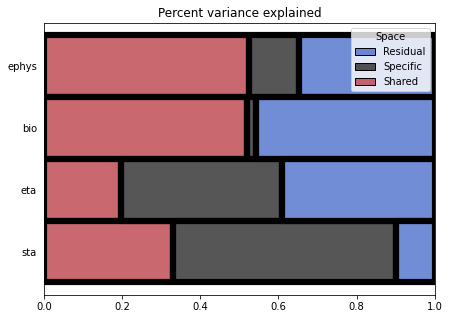

<ipython-input-17-b117f348b41c>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticklabels=['ephys', 'bio','eta','sta'])


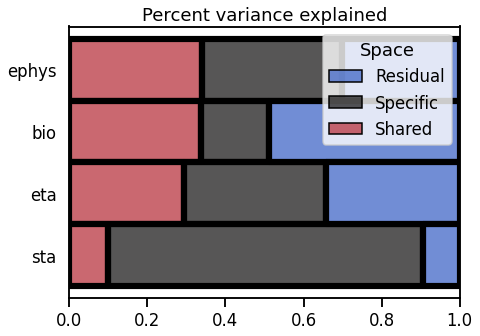

In [17]:
# sns.set_context('talk')
savepath = 'D:/Data For Publication/figures/part2/'
fig,ax = plt.subplots(figsize=(7, 5))
var_exp_totals_exc['Space'] = pd.Categorical(var_exp_totals_exc['Space'], ['Residual', 'Specific', 'Shared'])
sns.histplot(var_exp_totals_exc, y='dataset', hue='Space', weights='Variance explained',
             multiple='stack', palette='icefire',ax =ax)
ax.set(title='Percent variance explained', xlabel=None, ylabel=None)
ax.set_xlim(0, 1)
ax.tick_params(left=False)
ax.set_yticklabels=['ephys','bio','eta','sta']
plt.savefig(savepath+'alpha_exc.svg',dpi=100)
plt.show() 

# fig,ax = plt.subplots(figsize=(7, 5))

sns.set_context('talk')
plt.figure(figsize=(7, 5))
var_exp_totals_inh['Space'] = pd.Categorical(var_exp_totals_inh['Space'], ['Residual', 'Specific', 'Shared'])
ax = sns.histplot(var_exp_totals_inh, y='dataset', hue='Space', weights='Variance explained',
             multiple='stack', palette='icefire')
ax.set(title='Percent variance explained', xlabel=None, ylabel=None)
ax.set_xlim(0, 1)
ax.tick_params(left=False)
ax.set(yticklabels=['ephys', 'bio','eta','sta'])
plt.savefig(savepath+'beta_inh.svg',dpi=100)

plt.show() 

In [18]:
var_exp_normed_exc = var_exp_normed_exc.reindex(['ephys','bio','eta','sta'])
var_exp_normed_inh = var_exp_normed_inh.reindex(['ephys','bio','eta','sta'])



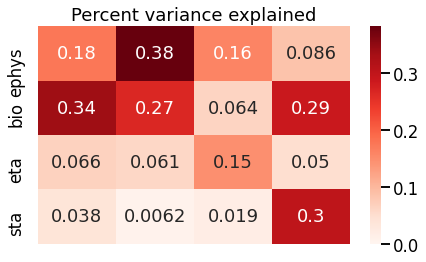

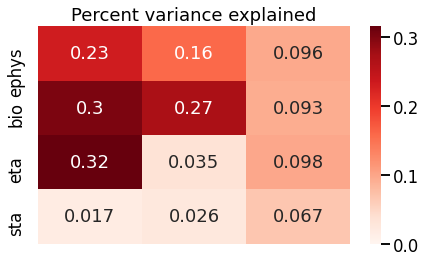

In [19]:

sns.set_context('talk')
plt.figure(figsize=(7, 4))
ax = sns.heatmap(var_exp_normed_exc, vmin=0, cmap='Reds',annot=True)
ax.set(xlabel=None, title='Percent variance explained', xticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.savefig(savepath+'exc_var_per_factor.pdf',dpi=200)
plt.show()


sns.set_context('talk')
plt.figure(figsize=(7, 4))
ax = sns.heatmap(var_exp_normed_inh, vmin=0, cmap='Reds',annot=True)
ax.set(xlabel=None, title='Percent variance explained', xticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.savefig(savepath+'inh_var_per_factor.pdf',dpi=200)

plt.show()

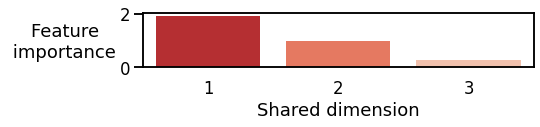

In [20]:
sns.set_context('talk')
plt.figure(figsize=(7, 1))
ax = sns.barplot(x=mcfa_res_inh.rho.index, y=mcfa_res_inh.rho, palette='Reds_r')
ax.set_ylabel('Feature   \n importance', rotation=0, y=0.1, ha='right')
ax.tick_params(bottom=False)
ax.set(xticklabels=range(1, 4))
ax.set(xlabel='Shared dimension')
plt.savefig(savepath+'shared_dim_inh.pdf',dpi=200)
plt.show()

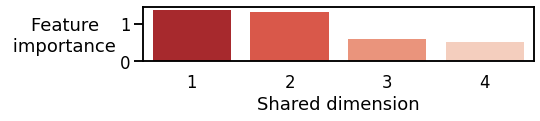

In [21]:
sns.set_context('talk')
plt.figure(figsize=(7, 1))
ax = sns.barplot(x=mcfa_res_exc.rho.index, y=mcfa_res_exc.rho, palette='Reds_r')
ax.set_ylabel('Feature   \n importance', rotation=0, y=0.1, ha='right')
ax.tick_params(bottom=False)
ax.set(xticklabels=range(1, 5))
ax.set(xlabel='Shared dimension')
plt.savefig(savepath+'shared_dim_exc.pdf',dpi=200)
plt.show()

# D1

In [73]:
from multicor_fa import mcfa_model


Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 1 components above rho inclusion threshold 1.8755911588668823.
Fitting the model.
iter: 0 Likelihood: 677.18603515625
Iter: 1 Likelihood: 676.3162841796875 Percent change: 0.0012860121764145186 Time (s): 0.00099945068359375
Iter: 2 Likelihood: 676.9722900390625 Percent change: -0.0009690291154120168 Time (s): 0.003999948501586914
Calculating feature importance.
Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 2 components above rho inclusion threshold 1.9589836597442627.
Fitting the model.
iter: 0 Likelihood: 558.2269287109375
Iter: 1 Likelihood: 555.8004150390625 Percent change: 0.0043658003956410524 Time (s): 0.004002571105957031
Iter: 2 Likelihood: 555.4953002929688 Percent change: 0.0005492661160820482 Time (s): 0.005993843078613281
Iter: 3 Likelihood: 555.38623046875 Percent change: 0.00019638553899093658 Time (s): 0.008507251739501953
Iter: 4 Likelihood: 555.3028564453125 Percent change: 0.00015014153532579724 Time (s): 0.01050710678100586
Iter: 5 Likelihood: 555.2296752929688 Percent change: 0.00013180338803961753 Time (s): 0.012508392333984375
Iter: 6 Likelihood: 555.1661987304688 Percent change: 0.00011433794536691101 Time (s): 0.014506816864013672
Iter: 7 Likelihood: 555.1119384765625 Percent change: 9.774650866843307e-05 Time (s): 0.015506505966186523
Iter: 8 Likelihood: 555.06488

In [74]:
# mcfa_res_inh_d1 = pd.concat([mcfa_res_inh_d1.Z] + list(mcfa_res_inh_d1.X.values()), axis=1)
# mcfa_res_exc_d1 = pd.concat([mcfa_res_exc_d1.Z] + list(mcfa_res_exc_d1.X.values()), axis=1)

In [85]:
def perform_MCFA(cond=None):
    if cond==None:
        raise 'Provide a drug condition'
    drug = [cond]

    ephys_drug_exc = return_neuromod_df(ephys_exc_all,cond=drug,cols=cols_ephys,df_type='ephys')
    sta_drug_exc   = return_neuromod_df(sta_exc_all,cond=drug,df_type='sta')
    bio_drug_exc   = return_neuromod_df(bio_exc_all,cond=drug,df_type='bio',cols=cols_bio)
    eta_drug_exc   = return_neuromod_df(bio_exc_all,cond=drug,df_type='eta')


    ephys_drug_inh = return_neuromod_df(ephys_inh_all,cond=drug,cols=cols_ephys,df_type='ephys')
    sta_drug_inh   = return_neuromod_df(sta_inh_all,cond=drug,df_type='sta')
    bio_drug_inh   = return_neuromod_df(bio_inh_all,cond=drug,df_type='bio',cols=cols_bio)
    eta_drug_inh   = return_neuromod_df(bio_inh_all,cond=drug,df_type='eta')



    Y_inh = {"ephys": ephys_drug_inh[cols_ephys].reset_index(drop='index'), 
            "bio"  : bio_drug_inh[cols_bio].reset_index(drop='index'), 
            "sta"  : sta_drug_inh,
            'eta'  : eta_drug_inh}

    Y_exc = {"ephys": ephys_drug_exc[cols_ephys].reset_index(drop='index'), 
            "bio"  : bio_drug_exc[cols_bio].reset_index(drop='index'), 
            "sta"  : sta_drug_exc,
            'eta'  : eta_drug_exc}
            



    mcfa_res_inh_d1 = mcfa_model.fit(Y_inh,center =True, k=[1,1,1,1],n_pcs= [2,2,2,2]) 
    mcfa_res_exc_d1 = mcfa_model.fit(Y_exc,center =True, k=[1,1,1,1],n_pcs= [2,2,2,2]) 



    var_exp_private_exc = {mode: ve_X.sum() for mode, ve_X in mcfa_res_exc_d1.var_exp_X.items()}
    var_exp_shared_exc = mcfa_res_exc_d1.var_exp_Z.sum()
    var_exp_totals_exc_d1 = pd.DataFrame({'Shared': var_exp_shared_exc, 'Specific': var_exp_private_exc})
    var_exp_totals_exc_d1['Total'] = var_exp_totals_exc_d1['Shared'] + var_exp_totals_exc_d1['Specific']
    var_exp_normed_exc = (mcfa_res_exc_d1.var_exp_Z/var_exp_totals_exc_d1['Total']).T
    var_exp_totals_exc_d1['Residual'] = 1 - var_exp_totals_exc_d1['Total']
    var_exp_totals_exc_d1 = var_exp_totals_exc_d1.drop('Total', axis=1)


    var_exp_private_inh = {mode: ve_X.sum() for mode, ve_X in mcfa_res_inh_d1.var_exp_X.items()}
    var_exp_shared_inh = mcfa_res_inh_d1.var_exp_Z.sum()
    var_exp_totals_inh_d1 = pd.DataFrame({'Shared': var_exp_shared_inh, 'Specific': var_exp_private_inh})
    var_exp_totals_inh_d1['Total'] = var_exp_totals_inh_d1['Shared'] + var_exp_totals_inh_d1['Specific']
    var_exp_normed_inh = (mcfa_res_inh_d1.var_exp_Z/var_exp_totals_inh_d1['Total']).T
    var_exp_totals_inh_d1['Residual'] = 1 - var_exp_totals_inh_d1['Total']
    var_exp_totals_inh_d1 = var_exp_totals_inh_d1.drop('Total', axis=1)


    var_exp_totals_exc_d1['dataset'] = var_exp_totals_exc_d1.index
    var_exp_totals_exc_d1 = var_exp_totals_exc_d1.melt(id_vars=['dataset'], var_name='Space', value_name='Variance explained')

    var_exp_totals_inh_d1['dataset'] = var_exp_totals_inh_d1.index
    var_exp_totals_inh_d1 = var_exp_totals_inh_d1.melt(id_vars=['dataset'], var_name='Space', value_name='Variance explained')


    # sns.set_context('talk')
    savepath = 'D:/Data For Publication/figures/part2/'
    fig,ax = plt.subplots(figsize=(7, 5))
    var_exp_totals_exc_d1['Space'] = pd.Categorical(var_exp_totals_exc_d1['Space'], ['Residual', 'Specific', 'Shared'])
    sns.histplot(var_exp_totals_exc_d1, y='dataset', hue='Space', weights='Variance explained',
                multiple='stack', palette='icefire',ax =ax)
    ax.set(title='Percent variance explained', xlabel=None, ylabel=None)
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_yticklabels=['ephys','bio','eta','sta']
    plt.savefig(savepath+'alpha_exc.svg',dpi=100)
    plt.show() 

    # fig,ax = plt.subplots(figsize=(7, 5))

    sns.set_context('talk')
    plt.figure(figsize=(7, 5))
    var_exp_totals_inh_d1['Space'] = pd.Categorical(var_exp_totals_inh_d1['Space'], ['Residual', 'Specific', 'Shared'])
    ax = sns.histplot(var_exp_totals_inh_d1, y='dataset', hue='Space', weights='Variance explained',
                multiple='stack', palette='icefire')
    ax.set(title='Percent variance explained', xlabel=None, ylabel=None)
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set(yticklabels=['ephys', 'bio','eta','sta'])
    plt.savefig(savepath+'beta_inh.svg',dpi=100)

    plt.show() 

Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 2 components above rho inclusion threshold 1.7004092931747437.
Fitting the model.
iter: 0 Likelihood: 980.1984252929688
Iter: 1 Likelihood: 977.9232177734375 Percent change: 0.002326570714530641 Time (s): 0.003025531768798828
Iter: 2 Likelihood: 977.5145874023438 Percent change: 0.0004180299469286163 Time (s): 0.006650447845458984
Iter: 3 Likelihood: 977.3618774414062 Percent change: 0.0001562471019815842 Time (s): 0.014730453491210938
Iter: 4 Likelihood: 977.2927856445312 Percent change: 7.069713180112498e-05 Time (s): 0.018944978713989258
Iter: 5 Likelihood: 977.2562866210938 Percent change: 3.734846624900922e-05 Time (s): 0.022134780883789062
Iter: 6 Likelihood: 977.2293090820312 Percent change: 2.7606150175583235e-05 Time (s): 0.02613377571105957
Iter: 7 Likelihood: 977.201416015625 Percent change: 2.8543825202361356e-05 Time (s): 0.03315901756286621
Iter: 8 Likelihood: 977.16973876

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 2 components above rho inclusion threshold 1.595760464668274.
Fitting the model.
iter: 0 Likelihood: 1377.007568359375
Iter: 1 Likelihood: 1373.4119873046875 Percent change: 0.0026179916062505073 Time (s): 0.003039836883544922
Iter: 2 Likelihood: 1372.19921875 Percent change: 0.0008838137626927577 Time (s): 0.006529331207275391
Iter: 3 Likelihood: 1371.5726318359375 Percent change: 0.0004568383033596795 Time (s): 0.011050701141357422
Iter: 4 Likelihood: 1371.171875 Percent change: 0.00029227323229445614 Time (s): 0.014322996139526367
Iter: 5 Likelihood: 1370.8834228515625 Percent change: 0.00021041333174595783 Time (s): 0.01734304428100586
Iter: 6 Likelihood: 1370.6610107421875 Percent change: 0.0001622663135756433 Time (s): 0.020363569259643555
Iter: 7 Likelihood: 1370.48095703125 Percent change: 0.00013137994367140585 Time (s): 0.023809194564819336
Iter: 8 Likelihood: 1370.32971191406

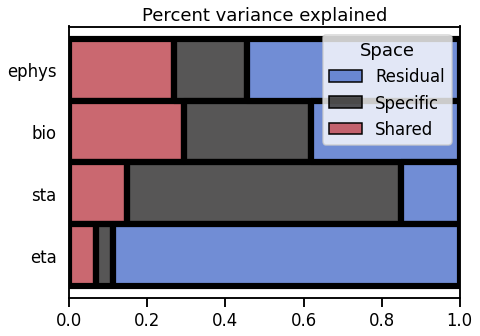

<ipython-input-85-aea2254f56f6>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticklabels=['ephys', 'bio','eta','sta'])


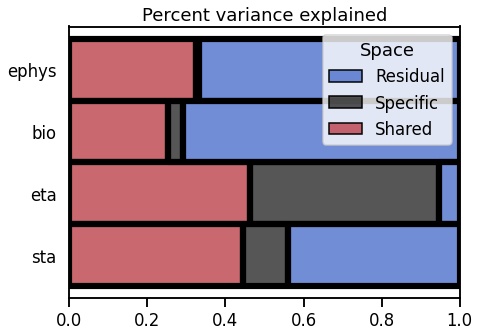

In [86]:
perform_MCFA('d1')

Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 2 components above rho inclusion threshold 1.9693585634231567.
Fitting the model.
iter: 0 Likelihood: 509.61639404296875
Iter: 1 Likelihood: 508.472900390625 Percent change: 0.002248878261683724 Time (s): 0.004980564117431641
Iter: 2 Likelihood: 508.1673278808594 Percent change: 0.0006013226215071957 Time (s): 0.010120391845703125
Iter: 3 Likelihood: 507.96875 Percent change: 0.0003909253883420486 Time (s): 0.013117313385009766
Iter: 4 Likelihood: 507.810546875 Percent change: 0.0003115396597679222 Time (s): 0.02067708969116211
Iter: 5 Likelihood: 507.67626953125 Percent change: 0.0002644940325337278 Time (s): 0.023676395416259766
Iter: 6 Likelihood: 507.5608215332031 Percent change: 0.0002274564803842385 Time (s): 0.027678251266479492
Iter: 7 Likelihood: 507.46136474609375 Percent change: 0.00019598888510288424 Time (s): 0.03591609001159668
Iter: 8 Likelihood: 507.3759765625 Percent ch

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 2 components above rho inclusion threshold 1.5874818563461304.
Fitting the model.
iter: 0 Likelihood: 1269.080810546875
Iter: 1 Likelihood: 1265.2735595703125 Percent change: 0.0030090338549834585 Time (s): 0.003997802734375
Iter: 2 Likelihood: 1263.17919921875 Percent change: 0.0016580073142890717 Time (s): 0.012996912002563477
Iter: 3 Likelihood: 1261.9400634765625 Percent change: 0.0009819291565827317 Time (s): 0.021007299423217773
Iter: 4 Likelihood: 1261.3935546875 Percent change: 0.00043325795270762513 Time (s): 0.029996871948242188
Iter: 5 Likelihood: 1260.9534912109375 Percent change: 0.0003489926310762594 Time (s): 0.03699970245361328
Iter: 6 Likelihood: 1260.544677734375 Percent change: 0.0003243149439949055 Time (s): 0.04562854766845703
Iter: 7 Likelihood: 1260.1697998046875 Percent change: 0.00029748207721340565 Time (s): 0.051969051361083984
Iter: 8 Likelihood: 1259.8280029

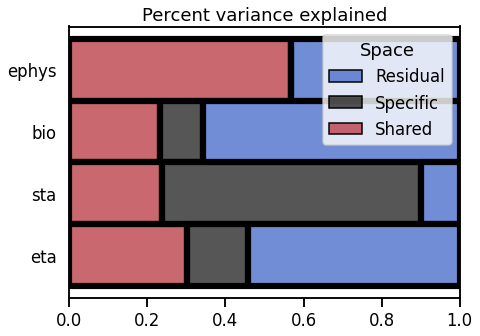

<ipython-input-85-aea2254f56f6>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticklabels=['ephys', 'bio','eta','sta'])


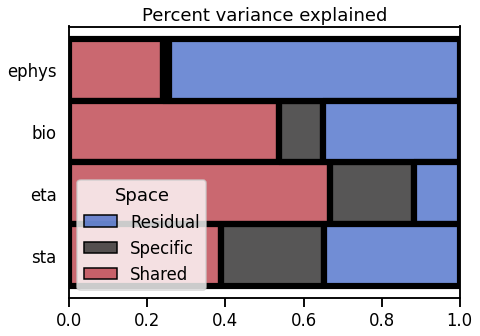

In [87]:
perform_MCFA('d2')

Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 2 components above rho inclusion threshold 1.9714149236679077.
Fitting the model.
iter: 0 Likelihood: 537.1027221679688
Iter: 1 Likelihood: 537.163818359375 Percent change: -0.00011373847105497942 Time (s): 0.008221626281738281
Calculating feature importance.
Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 2 components above rho inclusion threshold 1.986721158027649.
Fitting the model.
iter: 0 Likelihood: 499.9220886230469
Iter: 1 Likelihood: 498.13739013671875 Percent change: 0.003582743479340703 Time (s): 0.0034728050231933594
Iter: 2 Likelihood: 497.71917724609375 Percent change: 0.0008402587437739365 Time (s): 0.006495237350463867
Iter: 3 Likelihood: 497.4908447265625 Percent change: 0.0004589682844450115 Time (s): 0.009905099868774414
Iter: 4 Likelihood: 497.3389892578125 Percent change: 0.00030533594194297235 Time (s): 0.013913631439208984
Iter: 5 Likelihood: 497.23052978515625 Percent change: 0.00021812713853896552 Time (s): 0.01789546012878418
Iter: 6 Likelihood: 497.1416931152344 Percent change: 0.0001786948693946762 Time (s): 0.020900726318359375
Iter: 7 Likelihood: 497.0552978515625 Percent change: 0.00017381418937752785 Time (s): 0.02489638328552246
Iter: 8 Likelihood: 496.962

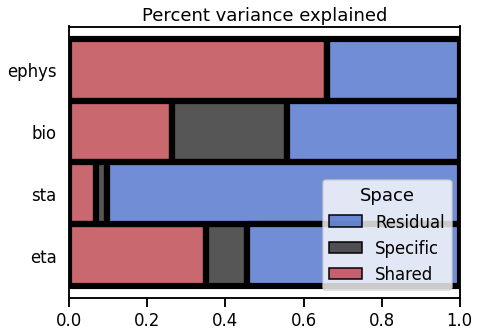

<ipython-input-85-aea2254f56f6>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticklabels=['ephys', 'bio','eta','sta'])


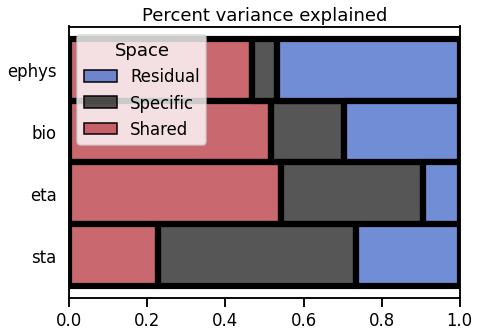

In [88]:
perform_MCFA('m1-ago')

Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 1 components above rho inclusion threshold 1.8960423469543457.
Fitting the model.
iter: 0 Likelihood: 677.18603515625
Iter: 1 Likelihood: 676.3162841796875 Percent change: 0.0012860121764145186 Time (s): 0.00401759147644043
Iter: 2 Likelihood: 676.9722900390625 Percent change: -0.0009690291154120168 Time (s): 0.011971712112426758
Calculating feature importance.
Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 2 components above rho inclusion threshold 1.914090871810913.
Fitting the model.
iter: 0 Likelihood: 558.2269287109375
Iter: 1 Likelihood: 555.8004150390625 Percent change: 0.0043658003956410524 Time (s): 0.002004384994506836
Iter: 2 Likelihood: 555.4953002929688 Percent change: 0.0005492661160820482 Time (s): 0.00738525390625
Iter: 3 Likelihood: 555.38623046875 Percent change: 0.00019638553899093658 Time (s): 0.009679555892944336
Iter: 4 Likelihood: 555.302734375 Percent change: 0.0001503613949316779 Time (s): 0.012700080871582031
Iter: 5 Likelihood: 555.2297973632812 Percent change: 0.00013136364810591758 Time (s): 0.015703678131103516
Iter: 6 Likelihood: 555.166259765625 Percent change: 0.0001144478731165574 Time (s): 0.018691062927246094
Iter: 7 Likelihood: 555.1119384765625 Percent change: 9.785645974680026e-05 Time (s): 0.023783445358276367
Iter: 8 Likelihood: 555.06494140625 Perc

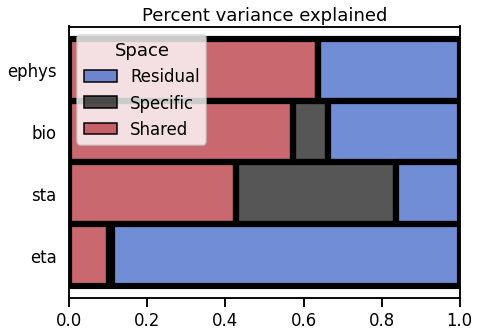

<ipython-input-85-aea2254f56f6>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticklabels=['ephys', 'bio','eta','sta'])


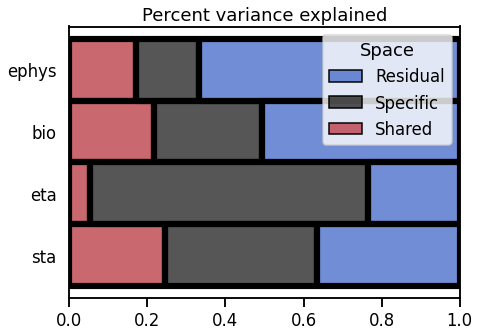

In [89]:
perform_MCFA('m1-ago+ant')